In [1]:
## !pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
from scipy import stats
import sklearn
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR, SVC, LinearSVC, LinearSVR
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, f_classif, VarianceThreshold, f_regression
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_letters
import seaborn as sns
import warnings

np.warnings.filterwarnings('ignore')
np.seterr(all='ignore')
sns.set(style="white")
warnings.filterwarnings("ignore",category=FutureWarning)
import matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
RNG=42

# Изучение восстановление пациентов после инсульта

Цель исследования: 

  * найти такие признаки, которые коррелируют с положительной динамикой по шкале Ранкина;
  * найти такие признаки, которые коррелируют с отрицательной динамикой.
  
https://en.wikipedia.org/wiki/Modified_Rankin_Scale

In [3]:
df = pd.read_csv('stroke_rehab_03.2019.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,ПОЛ,ВОЗРАСТ,Продолжительность образования (годы),Метобол с-м,Нарушение угл обмена,СД,Тяжесть АГ в анамнезе,Длительность АГ,ТИА,КУРЕНИЕ,...,Пирамидный с-м,ИАШОД10 ЦПРиН,Симптомы орального автоматизма,Поза Вернике-Манна,ПВИ_1.0,ПВИ_2.0,ПВИ_3.0,ПВИ_6.0,target,target binar
0,1.0,58.0,12.0,0.0,1.0,0.0,2.0,10.0,0.0,1.0,...,2.0,3.0,1.0,1.0,0,1,0,0,3.0,1.0
1,0.0,NaN,17.0,0.0,0.0,NaN,4.0,9.0,1.0,1.0,...,3.0,6.0,1.0,0.0,1,0,0,0,3.0,1.0
2,0.0,55.0,10.0,0.0,1.0,NaN,2.0,3.0,0.0,1.0,...,5.0,6.0,1.0,1.0,0,1,0,0,4.0,1.0
3,0.0,59.0,18.0,0.0,0.0,0.0,2.0,6.0,0.0,1.0,...,2.0,3.0,1.0,0.0,1,0,0,0,2.0,0.0
4,0.0,72.0,20.0,0.0,1.0,0.0,4.0,10.0,0.0,1.0,...,2.0,2.0,1.0,0.0,0,0,1,0,3.0,1.0


In [4]:
df.columns

Index(['ПОЛ', 'ВОЗРАСТ ', 'Продолжительность образования  (годы)',
       'Метобол с-м', 'Нарушение угл обмена', 'СД', 'Тяжесть АГ в анамнезе',
       'Длительность АГ ', 'ТИА', 'КУРЕНИЕ', 'АЛКОГОЛЬ',
       'Неревматическая фибрилляция предсердий (МКБ I48)',
       'Другие нарушение сердечного ритма', 'ЗАБОЛЕ-ВАНИЯ СЕРДЦА',
       'Количество потенциальных источников кардиогенной эмболии ', 'ИМТ',
       'ОЖИРЕНИЕ', 'Низкая физическая активность ', 'ХроничскийСтресс',
       'Количество НФР ', 'Общее Количествово ФР', 'Объём очага см3',
       ' АТ МАГ', 'Дис липидемия', 'ГТИ', 'Двигательные нарушения ОНМК',
       'логопед занятия ОНМК', 'СТЛ', 'ЛТЛ', 'NIHSS     1 сутки',
       'NIHSS    21 сутки ', 'Bаrtеl      21 сутки', 'Renk 21 сутки',
       'ИМР поступление ЦПРиН ', 'NIHSS  поступл ЦПРиН ',
       'M-Ash рука (поступление) ЦПРиН  ', 'M-Ash нога (поступление) ЦПРиН ',
       'Вейс рука (поступление) ЦПРиН ', 'Вейс нога (поступление) ЦПРиН ',
       'Индекс Хаузера ЦПРиН ', 'Инд

In [5]:
np.unique(df.target, return_counts=True)

(array([1., 2., 3., 4., 5., 6.]), array([ 1, 19, 21,  7,  1,  2]))

In [6]:
df['target binar'].head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: target binar, dtype: float64

In [7]:
features = ['ПОЛ', 'ВОЗРАСТ ', 'Продолжительность образования  (годы)',
            'Метобол с-м', 'Нарушение угл обмена', 'СД', 'Тяжесть АГ в анамнезе',
            'Длительность АГ ', 'ТИА', 'КУРЕНИЕ', 'АЛКОГОЛЬ',
            'Неревматическая фибрилляция предсердий (МКБ I48)',
            'Другие нарушение сердечного ритма', 'Низкая физическая активность ', 
            'ХроничскийСтресс', 'Количество потенциальных источников кардиогенной эмболии ', 'ИМТ', 
            'Количество НФР ', 'Дис липидемия', 'Общее Количествово ФР',
            'Объём очага см3' , 'ГТИ', 'Двигательные нарушения ОНМК', 'логопед занятия ОНМК', 
            'СТЛ', 'ЛТЛ', 'NIHSS     1 сутки', 'NIHSS    21 сутки ', 'Bаrtеl      21 сутки',
            'Renk 21 сутки', 'ИМР поступление ЦПРиН ', 'NIHSS  поступл ЦПРиН ',
            'M-Ash рука (поступление) ЦПРиН  ', 'M-Ash нога (поступление) ЦПРиН ',
            'Вейс рука (поступление) ЦПРиН ', 'Вейс нога (поступление) ЦПРиН ',
            'Индекс Хаузера ЦПРиН ', 'Индекс Холдена ЦПРиН ', 'Bаrtеl      поступление ЦПРиН ', 
            'Псевдобульбарный с-м ЦПРиН ', 'ИАШОД10 ЦПРиН ', 'Симптомы орального автоматизма', 
            'Поза Вернике-Манна',  'ПВИ_2.0','ПВИ_1.0','ПВИ_3.0', 'ПВИ_6.0', ' АТ МАГ']

In [8]:
def is_continious(df):
    unique, counts = np.unique(df.dropna(), return_counts=True)
    return len(unique) >= 3

In [9]:
continious_features = [feature for feature in features if is_continious(df[feature])]
discrete_features = [feature for feature in features if not is_continious(df[feature])]

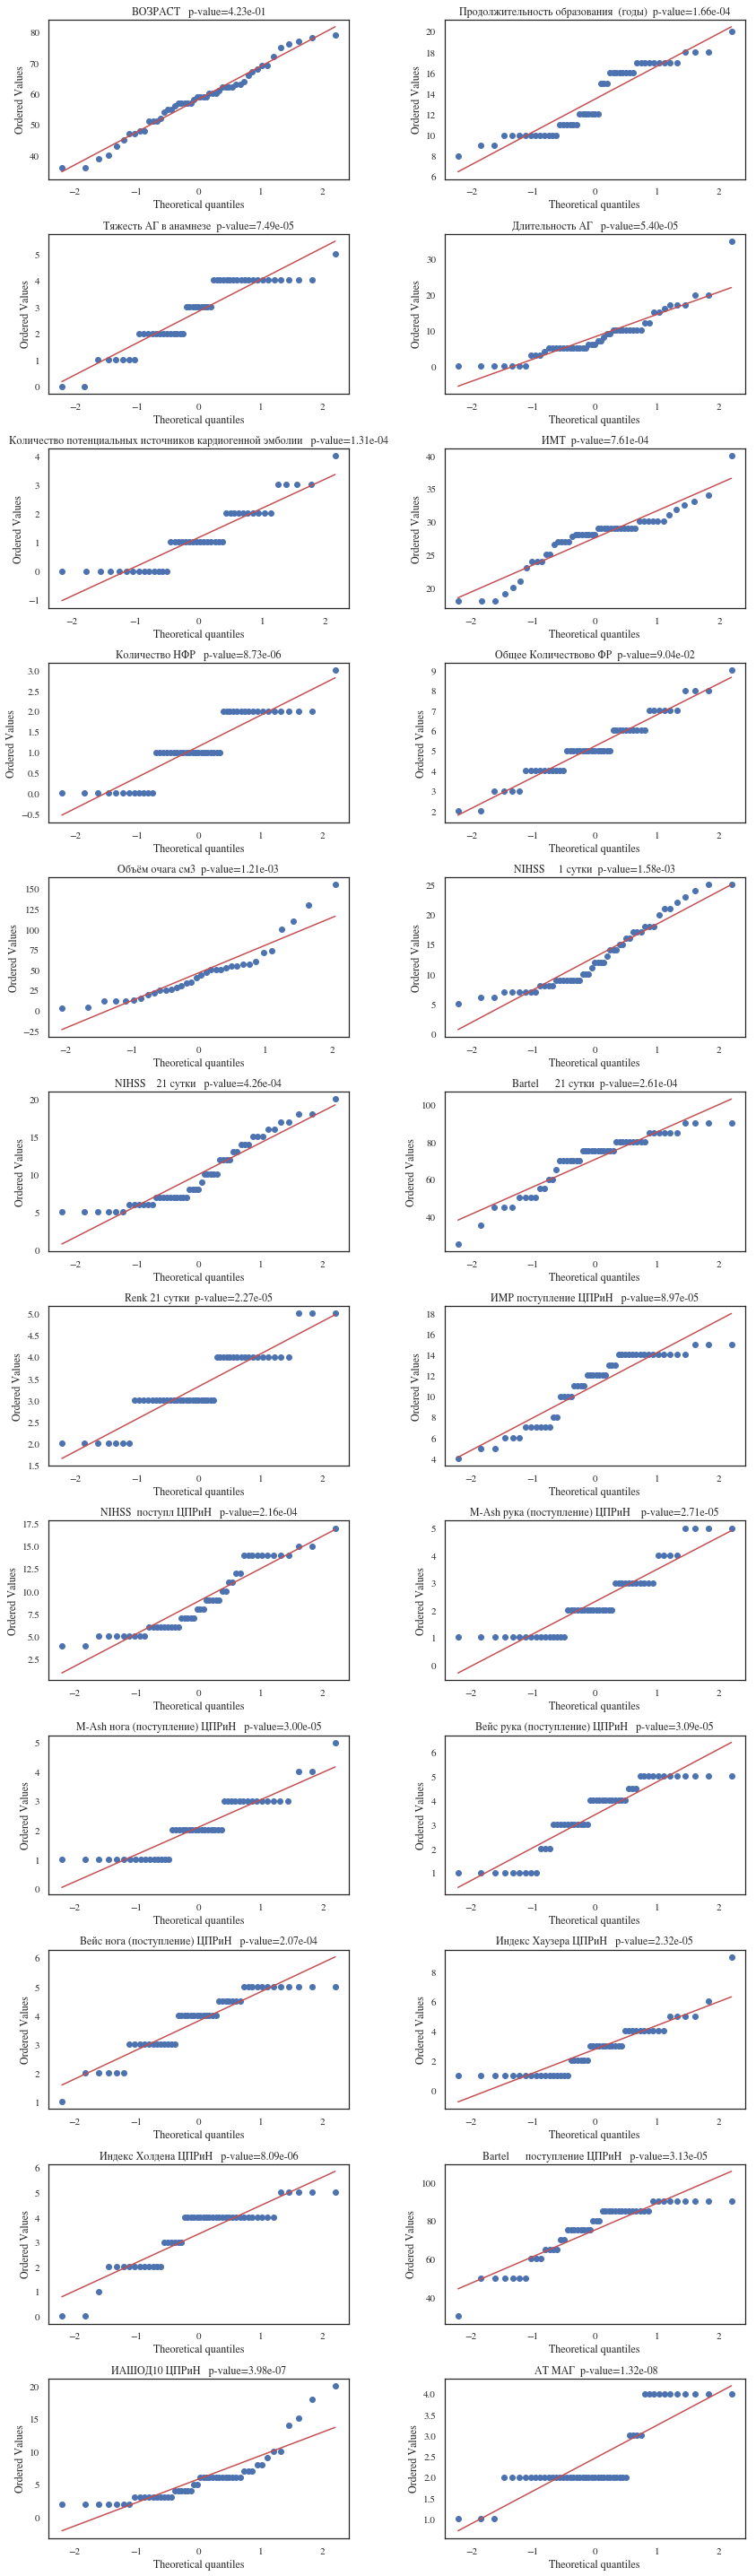

In [10]:
import scipy.stats as stats
fig, axes = plt.subplots(12, 2, figsize=(12, 40))

for i, feature in enumerate(continious_features):
    ax = axes[i // 2, i % 2]
    stats.probplot(df[feature].dropna(), dist="norm", plot=ax)
    ax.set_title(feature + '  p-value=' + "{:.2e}".format(stats.shapiro(df[feature].dropna())[1]))

plt.tight_layout()
plt.show()

## Подсчет статистик по датасету

Для категориальных переменных считаем проценты, для численных переменных - квантили.

In [12]:
aggregated_stats = [
    'Клинические данные',
    'Количество записей',
    'Количество положительных/Медиана',
    'Процент положительных,%/Квантиль [0.25,0.75]'
]

def mean_stats(df_full, statistics, columns, aggregated_stats):
    for i in columns:
        unique, counts = np.unique(df_full[i].dropna(), return_counts=True)
        if len(unique) < 3:
            statistics=statistics.append({aggregated_stats[0]: i,
                                          aggregated_stats[1]: counts.sum(),
                                          aggregated_stats[2]: counts[1],
                                          aggregated_stats[3]: int(counts[1] / counts.sum() * 100)}, 
                                             ignore_index=True)
        else:
            statistics=statistics.append({aggregated_stats[0]: i,
                                          aggregated_stats[1]: counts.sum(), 
                                          aggregated_stats[2]: round(np.median(df_full[i].dropna()), 2),
                                          aggregated_stats[3]: np.asarray(round(df_full[i].quantile([0.25, 0.75]), 2))},
                                          ignore_index=True)  
    return statistics

In [13]:
statistics_full = pd.DataFrame(columns=aggregated_stats)
statistics_full = mean_stats(df, statistics_full, columns=features, aggregated_stats=aggregated_stats)

In [14]:
statistics_full.head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]"
0,ПОЛ,51,25,49
1,ВОЗРАСТ,50,59,"[51.25, 63.0]"
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]"
3,Метобол с-м,50,10,20
4,Нарушение угл обмена,51,27,52


### Посчитаем статистики отдельно для двух групп 1 и 2 

In [15]:
def targeted_stats(df_full, statistics, columns, aggregated_stats):
    
    for i in columns:
        unique, counts = np.unique(df_full[i].dropna(), return_counts=True)
        if len(unique) < 3:
            try:
                statistics=statistics.append({
                                          aggregated_stats[0]: counts[1],
                                          aggregated_stats[1]: int(counts[1] / counts.sum() * 100)}, 
                                             ignore_index=True)
            
            
            except:
                statistics=statistics.append({
                                          aggregated_stats[0]: 0,
                                          aggregated_stats[1]: 0}, 
                                             ignore_index=True)
                
        else:
             statistics=statistics.append({
                                           aggregated_stats[0]: round(np.median(df_full[i].dropna()), 2),
                                           aggregated_stats[1]: np.asarray(round(df_full[i].quantile([0.25, 0.75]),2))}, 
                                             ignore_index=True)
    return statistics

In [18]:
aggregated_stats = ['Количество положительных/Медиана mRS 0–2',
                    'Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2']

In [19]:
df_pos = df[df['target binar']==1]
statistics_pos = pd.DataFrame(columns=aggregated_stats)
statistics_pos = targeted_stats(df_pos, statistics_pos, columns=features, aggregated_stats=aggregated_stats)
statistics_pos.head()

,Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2"
0,15,48
1,57,"[51.0, 62.75]"
2,12,"[11.0, 16.5]"
3,5,16
4,17,54


In [20]:
# для второй группы
df_neg = df[df['target binar']==0]
aggregated_stats=['Количество положительных/Медиана mRS 3–6',
                  'Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6']

In [21]:
statistics_neg = pd.DataFrame(columns=aggregated_stats)
statistics_neg = targeted_stats(df_neg, statistics_neg, columns=features, aggregated_stats=aggregated_stats)
statistics_neg.head()

,Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6"
0,10,50
1,59.5,"[56.75, 65.0]"
2,11.5,"[10.0, 16.25]"
3,5,25
4,10,50


In [22]:
statistics_neg.shape, statistics_pos.shape, statistics_full.shape

((48, 2), (48, 2), (48, 4))

In [23]:
# и вот мы получили таблицу 1 как в статье, почти, 
# осталось только посчитать p-value по группам
statistics = pd.concat([statistics_full, statistics_pos, statistics_neg], axis=1)
statistics.head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6"
0,ПОЛ,51,25,49,15,48,10,50
1,ВОЗРАСТ,50,59,"[51.25, 63.0]",57,"[51.0, 62.75]",59.5,"[56.75, 65.0]"
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]",12,"[11.0, 16.5]",11.5,"[10.0, 16.25]"
3,Метобол с-м,50,10,20,5,16,5,25
4,Нарушение угл обмена,51,27,52,17,54,10,50


#### Пример exact fisher test 

In [24]:
df.shape

(51, 53)

In [25]:
table = df.groupby(by=['target binar'])['ПОЛ'].sum()
print(table)

target binar
0.0    10.0
1.0    15.0
Name: ПОЛ, dtype: float64


In [26]:
np.array([
    np.unique(df[df['target binar'] == 0]['ПОЛ'], return_counts=True)[1], \
    np.unique(df[df['target binar'] == 1]['ПОЛ'], return_counts=True)[1]])

array([[10, 10],
       [16, 15]])

In [27]:
oddsratio, pvalue = stats.fisher_exact(np.array([[10, 10],
                                                 [16, 15]]))
print("OddsR: ", oddsratio, "p-Value:", pvalue)

OddsR:  0.9375 p-Value: 1.0


In [28]:
stats.fisher_exact(np.array([
    np.unique(df[df['target binar'] == 0]['ПОЛ'], return_counts=True)[1], \
    np.unique(df[df['target binar'] == 1]['ПОЛ'], return_counts=True)[1]]))

(0.9375, 1.0)

#### Добавим вероятности, для этого нужно будет заполнить пропуски

In [29]:
dropna = False

In [30]:
df = df.apply(pd.to_numeric)
if dropna:
    df.dropna(inplace=True)
else:
    inputer = SimpleImputer(strategy='median')
    df[features] = inputer.fit_transform(df[features])

## Считаем статистику в истинных баллах Renk

In [31]:
from scipy.stats import mannwhitneyu, ttest_ind, fisher_exact

def mannwhitneyu_Xy(X, y):
    p_values = []
    stats = []
    for col in X.columns:
        stat, p_val = mannwhitneyu(X[col], y)
        stats.append(stat); p_values.append(p_val)
        
    return np.array(stats), np.array(p_values)


def ttest_ind_Xy(X, y):
    p_values = []
    stats = []
    for col in X.columns:
        stat, p_val = ttest_ind(X[col], y)
        stats.append(stat); p_values.append(p_val)
        
    return np.array(stats), np.array(p_values)

def exact_fisher_test(X, df):
    p_values = []
    stats = []
    for i, row in X.iterrows():
        
        try:
            oddsratio, p_val = fisher_exact(
                np.array([
                    np.unique(df[df['target binar'] == 0][row['Клинические данные']], 
                              return_counts=True)[1], \
                    np.unique(df[df['target binar'] == 1][row['Клинические данные']], 
                              return_counts=True)[1]]))        
        except:
            oddsratio, p_val = 1e9, 1e9
        stats.append(oddsratio); p_values.append(p_val)
    return np.array(stats), np.array(p_values)

In [32]:
X = df[features][df['target'].notna()]
y = df['target'][df['target'].notna()]

In [33]:
statistics=pd.concat([statistics, pd.DataFrame(chi2(X, y)[1],
                                                    columns=['mRS ch2 p-value'])], axis=1)
statistics=pd.concat([statistics, pd.DataFrame(chi2(X, y)[0],
                                                    columns=['mRS ch2 statistics'])], axis=1)

In [34]:
statistics[statistics['mRS ch2 p-value'] < 0.05].sort_values(by=['mRS ch2 p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics
20,Объём очага см3,34,42,"[22.0, 56.5]",50,"[31.75, 57.75]",25,"[11.5, 51.25]",1.436078e-47,229.402897
28,Bаrtеl 21 сутки,51,75,"[62.5, 80.0]",70,"[52.5, 77.5]",80,"[73.75, 85.0]",2.976759e-21,105.922595
38,Bаrtеl поступление ЦПРиН,50,80,"[65.0, 85.0]",75,"[60.0, 85.0]",85,"[75.0, 90.0]",3.236197e-17,86.748071
26,NIHSS 1 сутки,51,12,"[8.5, 17.0]",14,"[9.0, 19.0]",9,"[7.0, 13.25]",2.836341e-09,48.478500
27,NIHSS 21 сутки,51,8,"[7.0, 13.5]",12,"[7.0, 15.0]",7,"[5.75, 10.0]",3.906619e-08,42.880702


In [35]:
# anova/ftest
statistics = pd.concat([statistics,pd.DataFrame(f_regression(X, y)[1],
                                                columns=['mRS ftest p-value'])], axis=1)

statistics = pd.concat([statistics,pd.DataFrame(f_regression(X, y)[0],
                                                columns=['mRS ftest statistics'])], axis=1)

In [36]:
statistics[statistics['mRS ftest p-value'] < 0.05].sort_values(by=['mRS ftest p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,mRS ftest p-value,mRS ftest statistics
31,NIHSS поступл ЦПРиН,50,8,"[6.0, 12.0]",10,"[7.0, 14.0]",6,"[5.0, 7.25]",7.394186e-08,41.511826,0.000005,26.027609
38,Bаrtеl поступление ЦПРиН,50,80,"[65.0, 85.0]",75,"[60.0, 85.0]",85,"[75.0, 90.0]",3.236197e-17,86.748071,0.000015,23.183491
28,Bаrtеl 21 сутки,51,75,"[62.5, 80.0]",70,"[52.5, 77.5]",80,"[73.75, 85.0]",2.976759e-21,105.922595,0.000018,22.649031
27,NIHSS 21 сутки,51,8,"[7.0, 13.5]",12,"[7.0, 15.0]",7,"[5.75, 10.0]",3.906619e-08,42.880702,0.000068,18.964319
37,Индекс Холдена ЦПРиН,50,4,"[2.0, 4.0]",3,"[2.0, 4.0]",4,"[4.0, 4.0]",4.608098e-02,11.281203,0.000086,18.328673


In [37]:
# mannwhitney
statistics = pd.concat([statistics,pd.DataFrame(mannwhitneyu_Xy(X, y)[1],
                                                columns=['mRS mannwhitneyu p-value'])], axis=1)

statistics = pd.concat([statistics,pd.DataFrame(mannwhitneyu_Xy(X, y)[0],
                                                columns=['mRS mannwhitneyu statistics'])], axis=1)

In [38]:
statistics[statistics['mRS mannwhitneyu p-value'] < 0.05].sort_values(by=['mRS mannwhitneyu p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,mRS ftest p-value,mRS ftest statistics,mRS mannwhitneyu p-value,mRS mannwhitneyu statistics
45,ПВИ_3.0,51,2,3,2,6,0,0,0.721999,2.857143,0.868881,0.027538,6.947015e-21,1.0
25,ЛТЛ,51,3,5,3,9,0,0,0.119978,8.738095,0.009107,7.375591,9.979215e-21,1.5
8,ТИА,51,4,7,2,6,2,10,0.952966,1.112782,0.437148,0.613756,1.405589e-20,2.0
18,Дис липидемия,51,49,96,29,93,0,0,0.999763,0.116618,0.868881,0.027538,2.382463e-20,24.5
12,Другие нарушение сердечного ритма,51,8,15,5,16,3,15,0.759994,2.609023,0.439382,0.607760,4.610140e-20,4.0


In [39]:
# ttest
statistics = pd.concat([statistics,pd.DataFrame(ttest_ind_Xy(X, y)[1],
                                                columns=['mRS ttest p-value'])], axis=1)

statistics = pd.concat([statistics,pd.DataFrame(ttest_ind_Xy(X, y)[0],
                                                columns=['mRS ttest statistics'])], axis=1)

In [40]:
statistics[statistics['mRS ttest p-value'] < 0.05].sort_values(by=['mRS mannwhitneyu p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,mRS ftest p-value,mRS ftest statistics,mRS mannwhitneyu p-value,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics
45,ПВИ_3.0,51,2,3,2,6,0,0,0.721999,2.857143,0.868881,0.027538,6.947015e-21,1.0,3.613072e-36,-19.681042
25,ЛТЛ,51,3,5,3,9,0,0,0.119978,8.738095,0.009107,7.375591,9.979215e-21,1.5,1.220409e-35,-19.381748
8,ТИА,51,4,7,2,6,2,10,0.952966,1.112782,0.437148,0.613756,1.405589e-20,2.0,3.949117e-35,-19.095544
18,Дис липидемия,51,49,96,29,93,0,0,0.999763,0.116618,0.868881,0.027538,2.382463e-20,24.5,7.532091e-24,-13.301670
12,Другие нарушение сердечного ритма,51,8,15,5,16,3,15,0.759994,2.609023,0.439382,0.607760,4.610140e-20,4.0,2.940053e-33,-18.065665


In [41]:
# exact_fisher_test
statistics = pd.concat([statistics,pd.DataFrame(exact_fisher_test(statistics, df)[1],
                                                columns=['mRS exact_fisher p-value'])], axis=1)

statistics = pd.concat([statistics,pd.DataFrame(exact_fisher_test(statistics, df)[0],
                                                columns=['mRS exact_fisher statistics'])], axis=1)

In [42]:
statistics[statistics['mRS exact_fisher p-value'] < 0.05].sort_values(by=['mRS exact_fisher p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,mRS ftest p-value,mRS ftest statistics,mRS mannwhitneyu p-value,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics
41,Симптомы орального автоматизма,51,42,82,29,93,13,65,0.873743,1.817759,0.010352,7.110893,1.373225e-19,21.0,2.078820e-24,-13.569018,0.019814,7.807692
42,Поза Вернике-Манна,50,15,30,13,43,2,10,0.029347,12.430075,0.016890,6.118679,1.988139e-19,7.5,1.601134e-30,-16.614621,0.025739,6.500000
39,Псевдобульбарный с-м ЦПРиН,50,32,64,23,76,9,45,0.716316,2.894053,0.021001,5.687421,4.359457e-19,16.5,9.009768e-26,-14.227786,0.034196,4.190476


## Считаем статистику в бинарных баллах Rankin

In [43]:
X = df[features][df['target'].notna()]
y = df['target binar'][df['target binar'].notna()]

In [44]:
statistics = pd.concat([statistics,
                       pd.DataFrame(chi2(X, y)[1],
                                   columns=['mRS ch2 binar p-value'])], axis=1)
statistics = pd.concat([statistics,
                       pd.DataFrame(f_classif(X, y)[1],
                                   columns=['mRS ftest binar p-value'])], axis=1)

statistics = pd.concat([statistics, 
                       pd.DataFrame(mannwhitneyu_Xy(X, y)[1],
                                    columns=['mRS mannwhitneyu binar p-value'])], axis=1)

statistics = pd.concat([statistics,
                        pd.DataFrame(ttest_ind_Xy(X, y)[1],
                                     columns=['mRS ttest binar p-value'])], axis=1)

statistics = pd.concat([statistics,
                        pd.DataFrame(exact_fisher_test(statistics, df)[1],
                                     columns=['mRS exact_fisher binar p-value'])], axis=1)

In [45]:
statistics[statistics['mRS ftest binar p-value']<0.05].sort_values(by=['mRS ftest binar p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
31,NIHSS поступл ЦПРиН,50,8,"[6.0, 12.0]",10,"[7.0, 14.0]",6,"[5.0, 7.25]",7.394186e-08,41.511826,...,42.0,1.652749e-19,11.271349,1.000000e+09,1.000000e+09,0.000092,0.000924,3.678474e-19,2.701470e-29,1.000000e+09
29,Renk 21 сутки,51,3,"[3.0, 4.0]",4,"[3.0, 4.0]",3,"[2.75, 3.0]",6.695651e-01,3.197513,...,893.5,1.817317e-02,2.401541,1.000000e+09,1.000000e+09,0.192340,0.001810,1.891101e-19,4.131055e-38,1.000000e+09
13,Низкая физическая активность,51,40,78,20,64,0,0,8.169576e-01,2.226786,...,20.0,1.183602e-24,-13.686491,1.000000e+09,1.000000e+09,0.162413,0.002083,2.719370e-02,5.341367e-02,1.000000e+09
34,Вейс рука (поступление) ЦПРиН,50,4,"[3.0, 4.5]",3,"[1.0, 4.0]",4.25,"[3.75, 5.0]",8.436847e-03,15.497042,...,925.0,3.447343e-02,2.143800,1.000000e+09,1.000000e+09,0.024537,0.002280,3.635748e-16,4.415246e-24,1.000000e+09
36,Индекс Хаузера ЦПРиН,50,3,"[1.0, 4.0]",3,"[2.0, 4.0]",1,"[1.0, 3.0]",3.850490e-05,27.875000,...,1177.5,6.189231e-01,-0.498932,1.000000e+09,1.000000e+09,0.005910,0.005516,8.412587e-14,6.885382e-14,1.000000e+09


In [46]:
statistics[statistics['mRS ch2 binar p-value']<0.05].sort_values(by=['mRS ch2 binar p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
20,Объём очага см3,34,42,"[22.0, 56.5]",50,"[31.75, 57.75]",25,"[11.5, 51.25]",1.436078e-47,229.402897,...,47.0,1.310538e-17,10.400846,1.000000e+09,1.000000e+09,1.046927e-19,0.032829,3.311482e-19,7.407956e-19,1.000000e+09
28,Bаrtеl 21 сутки,51,75,"[62.5, 80.0]",70,"[52.5, 77.5]",80,"[73.75, 85.0]",2.976759e-21,105.922595,...,0.0,4.961489e-54,31.747709,1.000000e+09,1.000000e+09,8.684718e-06,0.012333,3.611916e-19,2.069080e-55,1.000000e+09
38,Bаrtеl поступление ЦПРиН,50,80,"[65.0, 85.0]",75,"[60.0, 85.0]",85,"[75.0, 90.0]",3.236197e-17,86.748071,...,0.0,1.229311e-58,35.629354,1.000000e+09,1.000000e+09,2.259415e-05,0.009535,3.396628e-19,5.778230e-60,1.000000e+09
26,NIHSS 1 сутки,51,12,"[8.5, 17.0]",14,"[9.0, 19.0]",9,"[7.0, 13.25]",2.836341e-09,48.478500,...,4.5,3.137039e-22,12.535608,1.000000e+09,1.000000e+09,3.316284e-05,0.006429,3.871632e-19,1.617229e-28,1.000000e+09
31,NIHSS поступл ЦПРиН,50,8,"[6.0, 12.0]",10,"[7.0, 14.0]",6,"[5.0, 7.25]",7.394186e-08,41.511826,...,42.0,1.652749e-19,11.271349,1.000000e+09,1.000000e+09,9.168696e-05,0.000924,3.678474e-19,2.701470e-29,1.000000e+09


In [47]:
statistics[statistics['mRS mannwhitneyu binar p-value']<0.05].sort_values(by=['mRS mannwhitneyu binar p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
29,Renk 21 сутки,51,3,"[3.0, 4.0]",4,"[3.0, 4.0]",3,"[2.75, 3.0]",6.695651e-01,3.197513,...,893.5,1.817317e-02,2.401541,1.000000e+09,1.000000e+09,1.923404e-01,0.001810,1.891101e-19,4.131055e-38,1.000000e+09
19,Общее Количествово ФР,51,5,"[4.0, 6.0]",5,"[4.0, 6.0]",5,"[5.0, 6.0]",9.887769e-01,0.582806,...,275.5,1.262061e-14,9.039047,1.000000e+09,1.000000e+09,7.358512e-01,0.621830,3.224566e-19,2.508895e-37,1.000000e+09
20,Объём очага см3,34,42,"[22.0, 56.5]",50,"[31.75, 57.75]",25,"[11.5, 51.25]",1.436078e-47,229.402897,...,47.0,1.310538e-17,10.400846,1.000000e+09,1.000000e+09,1.046927e-19,0.032829,3.311482e-19,7.407956e-19,1.000000e+09
38,Bаrtеl поступление ЦПРиН,50,80,"[65.0, 85.0]",75,"[60.0, 85.0]",85,"[75.0, 90.0]",3.236197e-17,86.748071,...,0.0,1.229311e-58,35.629354,1.000000e+09,1.000000e+09,2.259415e-05,0.009535,3.396628e-19,5.778230e-60,1.000000e+09
30,ИМР поступление ЦПРиН,50,12,"[8.0, 14.0]",10.5,"[7.0, 13.0]",14,"[11.75, 14.0]",4.219493e-04,22.492408,...,14.5,7.156276e-32,17.322750,1.000000e+09,1.000000e+09,1.292278e-02,0.008717,3.401419e-19,1.233306e-41,1.000000e+09


In [48]:
statistics[statistics['mRS ttest binar p-value']<0.05].sort_values(by=['mRS ttest binar p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
16,ИМТ,49,28,"[26.5, 29.0]",28,"[25.0, 29.0]",29,"[27.5, 29.5]",1.159638e-01,8.831809,...,0.0,1.857741e-64,41.111062,1.000000e+09,1.000000e+09,0.271138,0.167368,3.622081e-19,5.312034e-69,1.000000e+09
1,ВОЗРАСТ,50,59,"[51.25, 63.0]",57,"[51.0, 62.75]",59.5,"[56.75, 65.0]",5.701160e-03,16.436973,...,0.0,4.273548e-61,37.861798,1.000000e+09,1.000000e+09,0.102133,0.233393,3.959308e-19,6.942392e-63,1.000000e+09
38,Bаrtеl поступление ЦПРиН,50,80,"[65.0, 85.0]",75,"[60.0, 85.0]",85,"[75.0, 90.0]",3.236197e-17,86.748071,...,0.0,1.229311e-58,35.629354,1.000000e+09,1.000000e+09,0.000023,0.009535,3.396628e-19,5.778230e-60,1.000000e+09
28,Bаrtеl 21 сутки,51,75,"[62.5, 80.0]",70,"[52.5, 77.5]",80,"[73.75, 85.0]",2.976759e-21,105.922595,...,0.0,4.961489e-54,31.747709,1.000000e+09,1.000000e+09,0.000009,0.012333,3.611916e-19,2.069080e-55,1.000000e+09
2,Продолжительность образования (годы),51,12,"[10.0, 16.5]",12,"[11.0, 16.5]",11.5,"[10.0, 16.25]",9.305134e-01,1.342357,...,0.0,2.267778e-40,22.161750,1.000000e+09,1.000000e+09,0.637827,0.600490,3.555660e-19,5.717673e-49,1.000000e+09


In [49]:
statistics[statistics['mRS exact_fisher binar p-value']<0.05].sort_values(by=['mRS exact_fisher binar p-value']).head()

,Клинические данные,Количество записей,Количество положительных/Медиана,"Процент положительных,%/Квантиль [0.25,0.75]",Количество положительных/Медиана mRS 0–2,"Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2",Количество положительных/Медиана mRS 3–6,"Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6",mRS ch2 p-value,mRS ch2 statistics,...,mRS mannwhitneyu statistics,mRS ttest p-value,mRS ttest statistics,mRS exact_fisher p-value,mRS exact_fisher statistics,mRS ch2 binar p-value,mRS ftest binar p-value,mRS mannwhitneyu binar p-value,mRS ttest binar p-value,mRS exact_fisher binar p-value
41,Симптомы орального автоматизма,51,42,82,29,93,13,65,0.873743,1.817759,...,21.0,2.078820e-24,-13.569018,0.019814,7.807692,0.272701,0.008331,0.008234,0.015522,0.019814
42,Поза Вернике-Манна,50,15,30,13,43,2,10,0.029347,12.430075,...,7.5,1.601134e-30,-16.614621,0.025739,6.500000,0.040057,0.013976,0.000777,0.001250,0.025739
39,Псевдобульбарный с-м ЦПРиН,50,32,64,23,76,9,45,0.716316,2.894053,...,16.5,9.009768e-26,-14.227786,0.034196,4.190476,0.159957,0.017590,0.343261,0.685692,0.034196


In [50]:
statistics.columns

Index(['Клинические данные', 'Количество записей',
       'Количество положительных/Медиана',
       'Процент положительных,%/Квантиль [0.25,0.75]',
       'Количество положительных/Медиана mRS 0–2',
       'Процент положительных,%/Квантиль [0.25, 0.75] mRS 0–2',
       'Количество положительных/Медиана mRS 3–6',
       'Процент положительных,%/Квантиль [0.25,0.75] mRS 3–6',
       'mRS ch2 p-value', 'mRS ch2 statistics', 'mRS ftest p-value',
       'mRS ftest statistics', 'mRS mannwhitneyu p-value',
       'mRS mannwhitneyu statistics', 'mRS ttest p-value',
       'mRS ttest statistics', 'mRS exact_fisher p-value',
       'mRS exact_fisher statistics', 'mRS ch2 binar p-value',
       'mRS ftest binar p-value', 'mRS mannwhitneyu binar p-value',
       'mRS ttest binar p-value', 'mRS exact_fisher binar p-value'],
      dtype='object')

### Отбор статистик для анализа

In [51]:
continious_selectors = ['mRS ftest p-value', 'mRS mannwhitneyu p-value', 
                        'mRS ftest binar p-value', 'mRS mannwhitneyu binar p-value']

In [52]:
statistics_continious = statistics[statistics['Клинические данные'].isin(continious_features)]

In [53]:
mask_continious = np.sum((statistics_continious[continious_selectors] < 0.05).values, axis=1)

In [54]:
continious_features_selected = statistics_continious[mask_continious > 1]['Клинические данные'].to_list()

In [55]:
continious_features_selected

['ВОЗРАСТ ',
 'Продолжительность образования  (годы)',
 'Длительность АГ ',
 'Количество потенциальных источников кардиогенной эмболии ',
 'ИМТ',
 'Количество НФР ',
 'Общее Количествово ФР',
 'Объём очага см3',
 'NIHSS     1 сутки',
 'NIHSS    21 сутки ',
 'Bаrtеl      21 сутки',
 'Renk 21 сутки',
 'ИМР поступление ЦПРиН ',
 'NIHSS  поступл ЦПРиН ',
 'M-Ash рука (поступление) ЦПРиН  ',
 'M-Ash нога (поступление) ЦПРиН ',
 'Вейс рука (поступление) ЦПРиН ',
 'Вейс нога (поступление) ЦПРиН ',
 'Индекс Хаузера ЦПРиН ',
 'Индекс Холдена ЦПРиН ',
 'Bаrtеl      поступление ЦПРиН ',
 'ИАШОД10 ЦПРиН ',
 ' АТ МАГ']

In [56]:
discrete_selectors = ['mRS ch2 p-value', 'mRS mannwhitneyu p-value', 
                      'mRS ch2 binar p-value', 'mRS mannwhitneyu binar p-value',
                      'mRS exact_fisher p-value', 'mRS exact_fisher binar p-value']

In [57]:
statistics_discrete = statistics[statistics['Клинические данные'].isin(discrete_features)]

In [58]:
mask_discrete = np.sum((statistics_discrete[discrete_selectors] < 0.05).values, axis=1)

In [59]:
discrete_features_selected = statistics_discrete[mask_discrete > 1]['Клинические данные'].to_list()

In [60]:
discrete_features_selected

['Метобол с-м',
 'СД',
 'ТИА',
 'АЛКОГОЛЬ',
 'Неревматическая фибрилляция предсердий (МКБ I48)',
 'Другие нарушение сердечного ритма',
 'Низкая физическая активность ',
 'ХроничскийСтресс',
 'Дис липидемия',
 'ГТИ',
 'Двигательные нарушения ОНМК',
 'СТЛ',
 'ЛТЛ',
 'Псевдобульбарный с-м ЦПРиН ',
 'Симптомы орального автоматизма',
 'Поза Вернике-Манна',
 'ПВИ_1.0',
 'ПВИ_3.0',
 'ПВИ_6.0']

## Корреляция данных и линейная модель

Данные очень скореллированы.

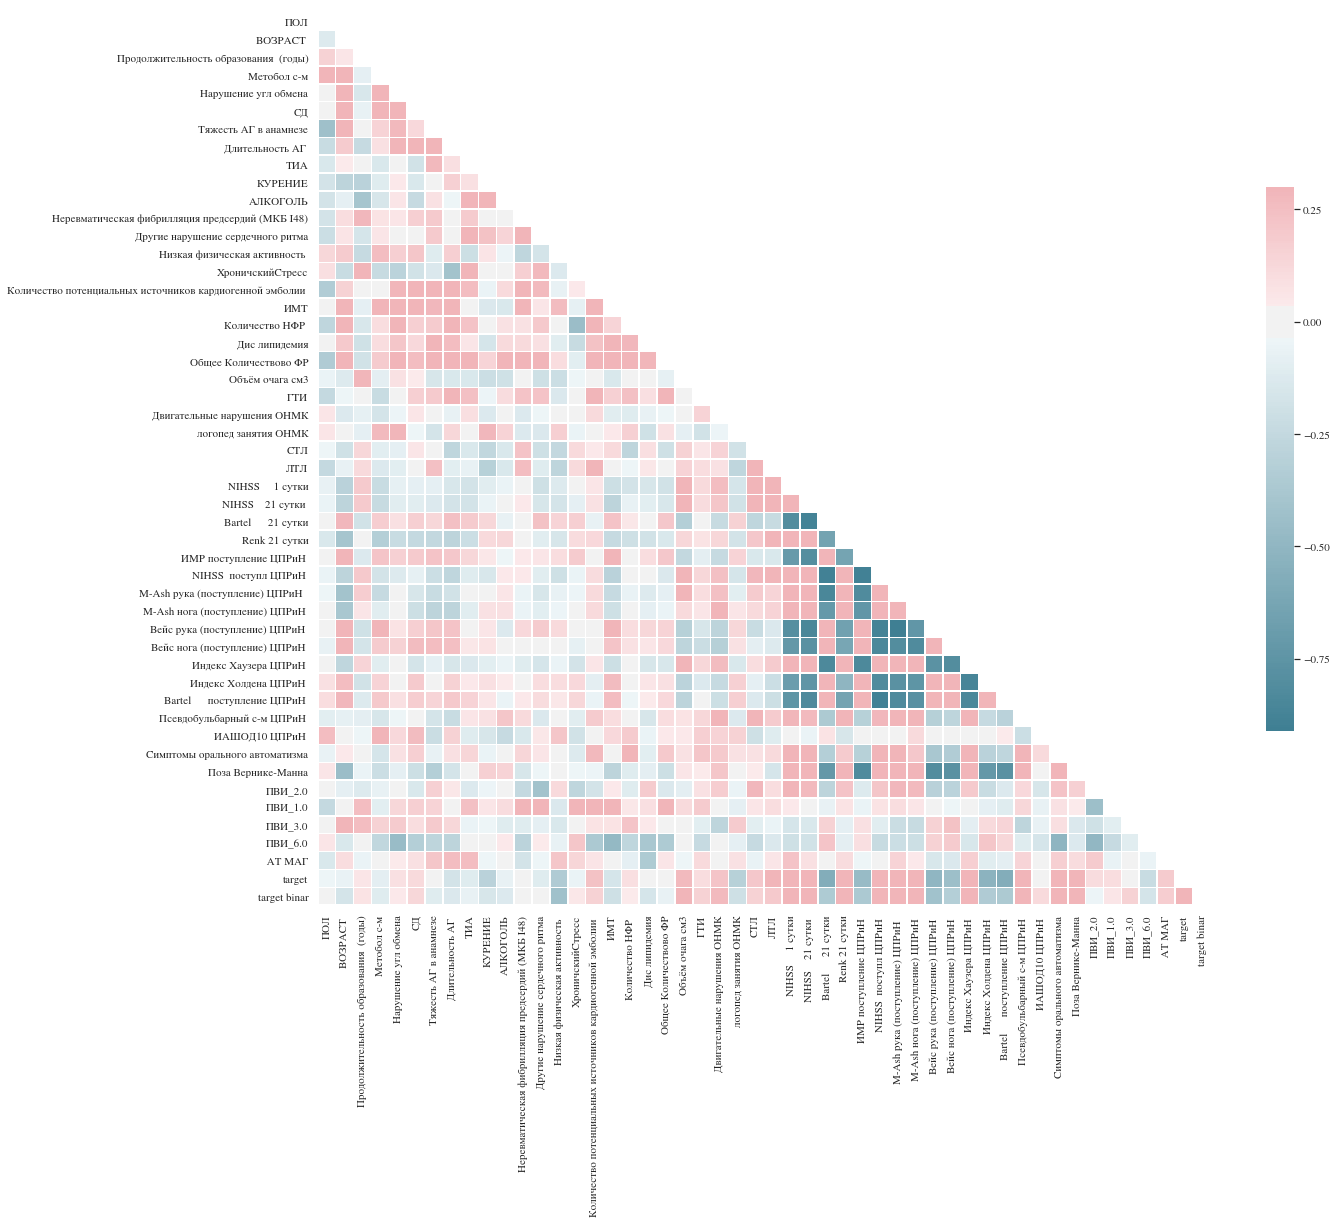

In [61]:
corr = (pd.concat([X[features], df[['target', 'target binar']]], axis=1)).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Три постановки эксперимента 

In [62]:
def plot_roc_curve(classifier, X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(15, 10))
    i = 0
    for train, test in cv.split(X, y.astype(int)):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')


    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Чувствительность')
    plt.ylabel('1 -Специфичность')
    plt.title('ROC-кривая модели классификации "Функциональный исход заболевания"')
    plt.legend(loc="lower right")
    plt.show()

### Все фичи

In [63]:
k = [5, 7, 9, 11, 13, 15]
knn = KNeighborsClassifier(n_jobs=-1)
logreg = LogisticRegression(random_state=RNG, max_iter = 3000)
rfr = RandomForestClassifier(n_jobs=-1, random_state=RNG)

In [64]:
pipe_clf = Pipeline([
    ('clf', KNeighborsClassifier()),
])

param_grid = [
    {
        'clf': [knn],
        'clf__n_neighbors': [1, 2, 3, 4, 5, 8, 10]
    },       
    {
        'clf': [logreg],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': np.logspace(-6, 0, 20),
        'clf__class_weight': ['balanced', None]
    },
    {
        'clf': [rfr],
        'clf__criterion' :['gini', 'entropy']
    }
]

CVgrid = GridSearchCV(estimator=pipe_clf, 
                      param_grid=param_grid, 
                      cv=4, 
                      scoring='roc_auc', 
                      n_jobs=-1, 
                      verbose=0)

CVgrid.fit(X, df['target binar'])
print ('Model best score:', CVgrid.best_score_ )
CVgrid.best_params_

Model best score: 0.773109243697479


{'clf': LogisticRegression(C=1.8329807108324375e-05, class_weight='balanced',
           dual=False, fit_intercept=True, intercept_scaling=1,
           max_iter=3000, multi_class='warn', n_jobs=None, penalty='l2',
           random_state=42, solver='warn', tol=0.0001, verbose=0,
           warm_start=False),
 'clf__C': 1.8329807108324375e-05,
 'clf__class_weight': 'balanced',
 'clf__penalty': 'l2'}

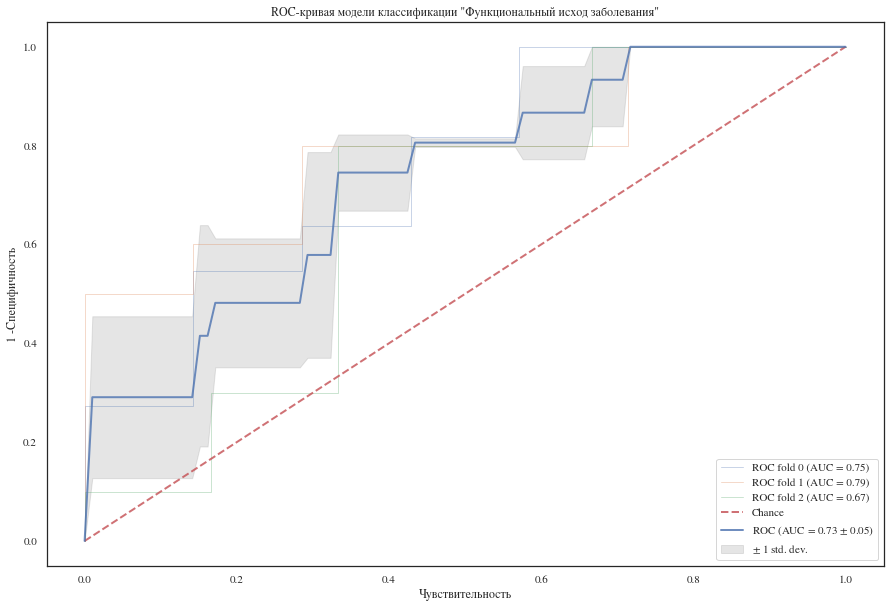

In [65]:
plot_roc_curve(CVgrid.best_estimator_, X=X, y=df['target binar'], n_splits=3)

## Авто выбор фичей

In [66]:
pipe_clf = Pipeline([
    ('dim_reduction', SelectKBest(f_classif)),
    ('clf', KNeighborsClassifier()),
])

param_grid = [
    {
        'dim_reduction': [SelectKBest(chi2), SelectKBest(f_classif)],
        'dim_reduction__k': k,
        'clf': [knn],
        'clf__n_neighbors': [1, 2, 3, 4, 5, 8, 10]
    },       
    {
        'dim_reduction': [SelectKBest(chi2), SelectKBest(f_classif)],
        'dim_reduction__k': k,
        'clf': [logreg],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': np.logspace(-6, 0, 20),
        'clf__class_weight': ['balanced', None]
    },
    {
        'dim_reduction': [SelectKBest(chi2), SelectKBest(f_classif)],
        'dim_reduction__k': k,
        'clf': [rfr],
        'clf__criterion' :['gini', 'entropy']
    }
]

CVgrid = GridSearchCV(estimator=pipe_clf, 
                      param_grid=param_grid, 
                      cv=5, 
                      scoring='roc_auc', 
                      n_jobs=-1, 
                      verbose=0)

CVgrid.fit(X, df['target binar'])
print ('Model best score:', CVgrid.best_score_)
CVgrid.best_params_

Model best score: 0.8148926237161531


{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=3000, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=42, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__penalty': 'l1',
 'dim_reduction': SelectKBest(k=7, score_func=<function f_classif at 0x7f8f26ed22f0>),
 'dim_reduction__k': 7}

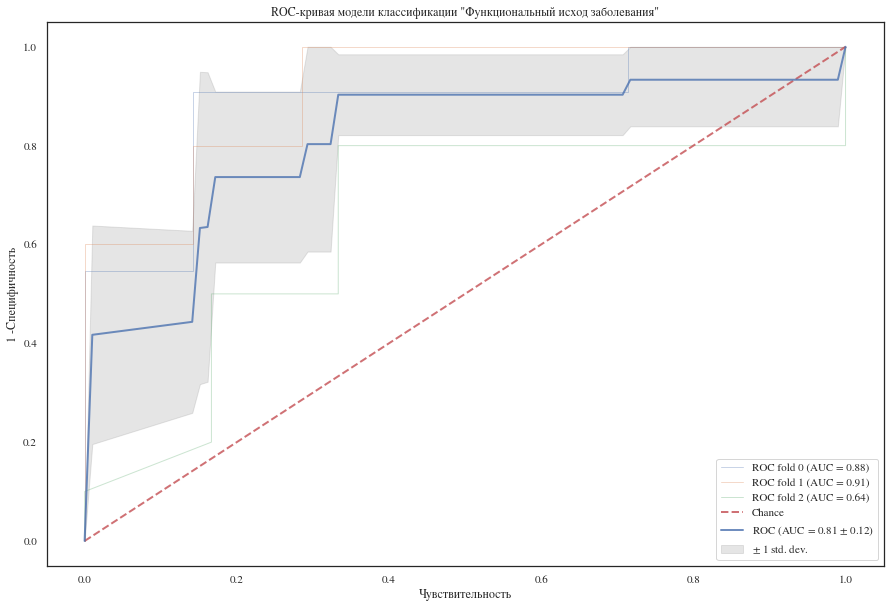

In [67]:
plot_roc_curve(CVgrid.best_estimator_, X=X, y=df['target binar'], n_splits=3)

## Наши фичи

In [68]:
pipe_clf = Pipeline([
    ('clf', KNeighborsClassifier()),
])

param_grid = [
    {
        'clf': [knn],
        'clf__n_neighbors': [1, 2, 3, 4, 5, 8, 10]
    },       
    {
        'clf': [logreg],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': np.logspace(-6, 0, 20),
        'clf__class_weight': ['balanced', None]
    },
    {
        'clf': [rfr],
        'clf__criterion': ['gini', 'entropy']
    }
]

CVgrid = GridSearchCV(estimator=pipe_clf, 
                      param_grid=param_grid, 
                      cv=4, 
                      scoring='roc_auc', 
                      n_jobs=-1, 
                      verbose=0)

CVgrid.fit(X[continious_features_selected + discrete_features_selected], df['target binar'])
print ('Model best score:', CVgrid.best_score_ )
CVgrid.best_params_

Model best score: 0.7766456582633053


{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
             oob_score=False, random_state=42, verbose=0, warm_start=False),
 'clf__criterion': 'entropy'}

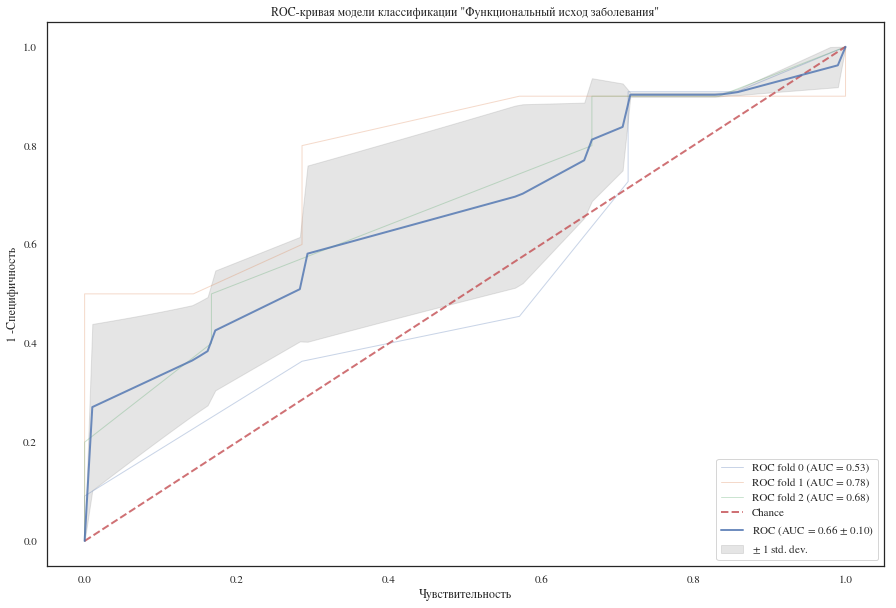

In [69]:
plot_roc_curve(CVgrid.best_estimator_, X=X[continious_features_selected + discrete_features_selected], 
               y=df['target binar'], n_splits=3)